# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [2]:
websites = pd.read_csv('../website.csv')
websites.sample()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
1239,B0_1327,62,13,UTF-8,Apache,12440.0,CA,Ontario,4/06/2010 0:00,7/04/2016 0:00,...,0,0,0,0,0,0,0,0,0.0,0


#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [3]:
websites.dtypes

URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
WHOIS_STATEPRO                object
WHOIS_REGDATE                 object
WHOIS_UPDATED_DATE            object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

In [4]:
websites.keys()

Index(['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

In [5]:
websites.shape

(1781, 21)

In [ ]:
'''
What the dataset looks like?
What are the data types?
    -> Objects and int/float
Which columns contain the features of the websites?
    - URL_LENGTH
    - NUMBER_SPECIAL_CHARACTERS
    - CONTENT_LENGTH
    - TCP_CONVERSATION_EXCHANGE
    - DIST_REMOTE_TCP_PORT
    - REMOTE_IPS
    - APP_BYTES
    - SOURCE_APP_PACKETS
    - REMOTE_APP_PACKETS
    - REMOTE_APP_BYTES
    - APP_PACKETS
    - DNS_QUERY_TYPES
Which column contains the feature we will predict?
    - Type
What is the code standing for benign vs malicious websites?
    -> Binary
Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?
    - CHARSET
    - SERVER
    - WHOIS_COUNTRY
    - WHOIS_STATEPRO
    - WHOIS_REGDATE
    - WHOIS_UPDATED_DATE
'''

#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [6]:
numeric = websites.select_dtypes(include=['int64', 'float64'])
correlation = numeric.corr()

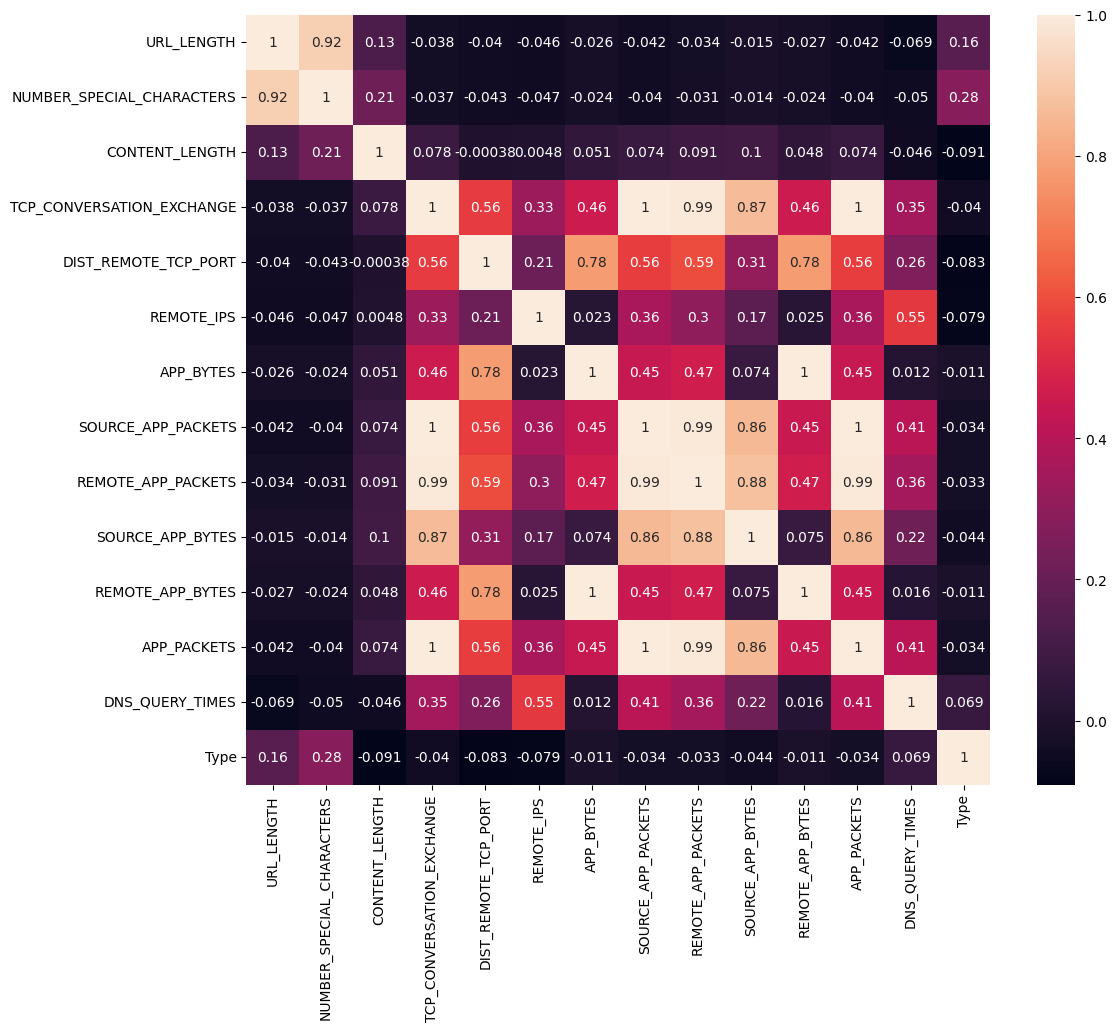

In [7]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True);

In [ ]:
#    - APP_BYTES
#    - SOURCE_APP_PACKETS
#    - REMOTE_APP_PACKETS
#    - APP_PACKETS
#    - NUMBER_SPECIAL_CHARACTERS

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [8]:
remove = ['APP_BYTES', 'SOURCE_APP_PACKETS', 'REMOTE_APP_PACKETS', 'APP_PACKETS', 'NUMBER_SPECIAL_CHARACTERS']
numeric_2 = numeric.drop(columns=remove)
correlation_filtered = numeric_2.corr()

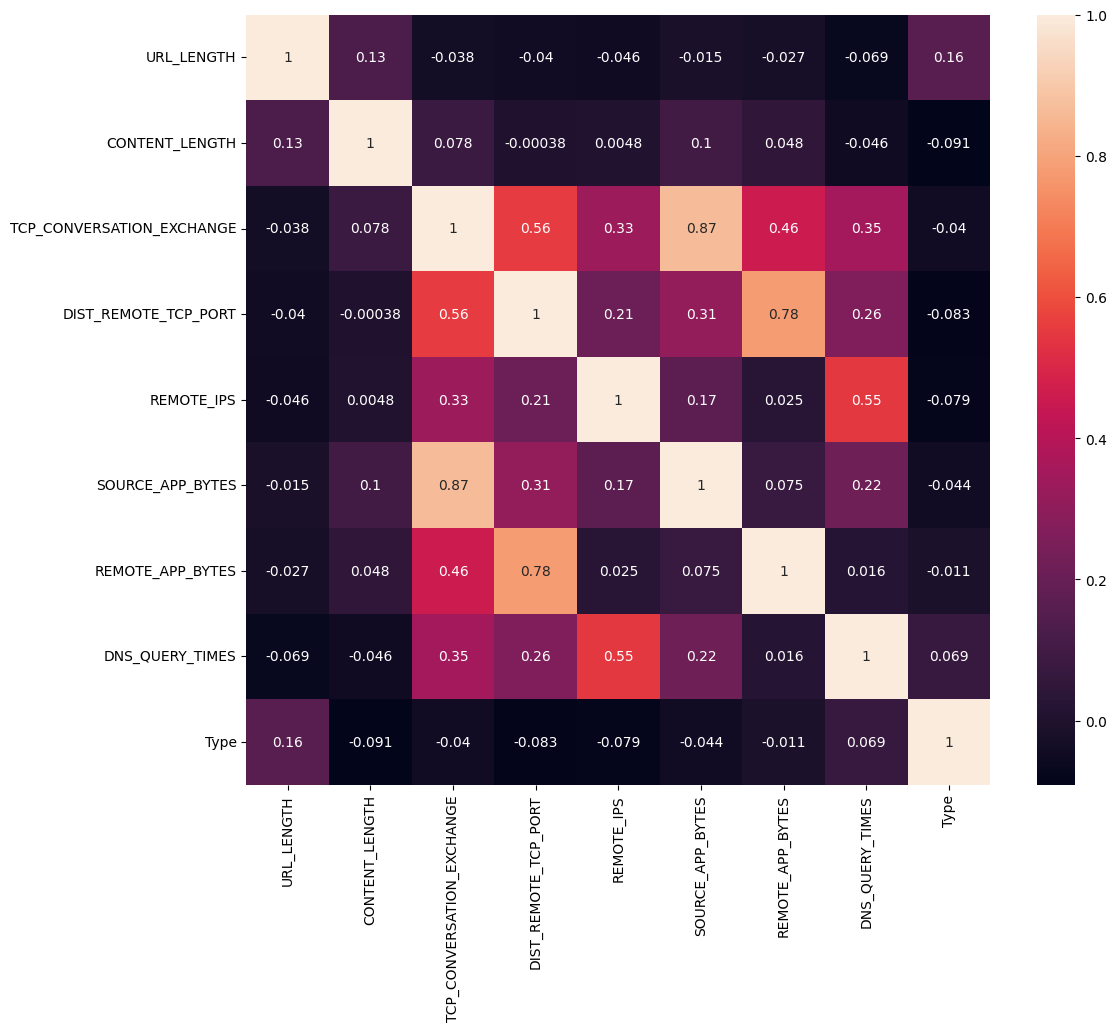

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_filtered, annot=True);

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [10]:
numeric_2.isnull().sum()

URL_LENGTH                     0
CONTENT_LENGTH               812
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [11]:
numeric_2.drop(columns='CONTENT_LENGTH', axis=1, inplace=True)

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [12]:
numeric_2.isnull().sum()

URL_LENGTH                   0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
DNS_QUERY_TIMES              1
Type                         0
dtype: int64

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [13]:
websites['WHOIS_COUNTRY'].unique()

array([nan, 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'se', 'IN',
       'LU', 'TH', "[u'GB'; u'UK']", 'FR', 'NL', 'UG', 'JP', 'CN', 'SE',
       'SI', 'IL', 'ru', 'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV',
       'DE', 'ES', 'BR', 'us', 'KR', 'HK', 'UA', 'CH', 'United Kingdom',
       'BS', 'PK', 'IT', 'Cyprus', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

In [14]:
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].str.upper()
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].replace({"[U'GB'; U'UK']": 'GB', 'SWEDEN': 'SE', 'UNITED KINGDOM': 'UK', 'CYPRUS': 'CY'})

websites['WHOIS_COUNTRY'].unique()

array([nan, 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'SE', 'IN',
       'LU', 'TH', 'FR', 'NL', 'UG', 'JP', 'CN', 'SI', 'IL', 'KY', 'AT',
       'CZ', 'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES', 'BR', 'KR', 'HK',
       'UA', 'CH', 'BS', 'PK', 'IT', 'CY', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

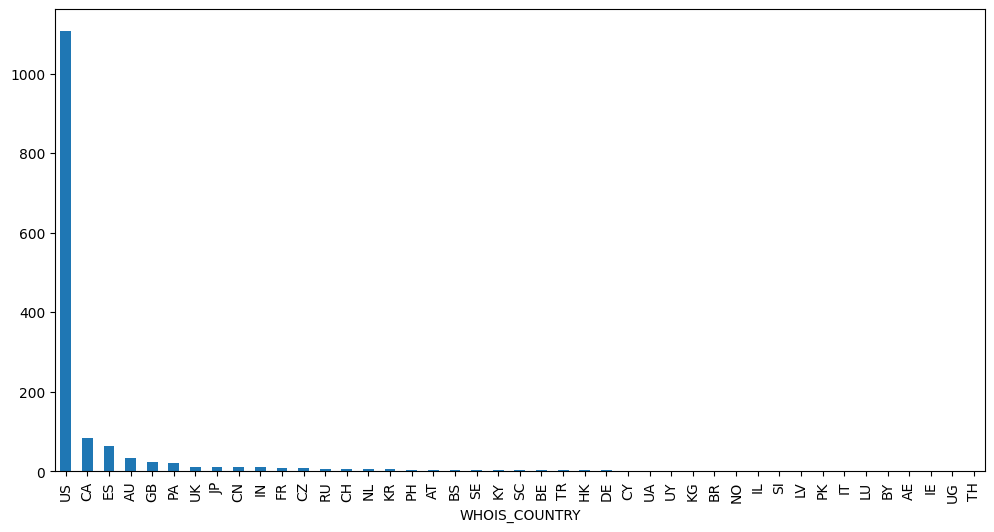

In [15]:
value = websites['WHOIS_COUNTRY'].value_counts()

plt.figure(figsize=(12, 6))
value.plot(kind='bar');

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [17]:
websites['WHOIS_COUNTRY'].value_counts().nlargest(10).index
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].apply(lambda x: x if x in websites else 'OTHER')

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [18]:
websites.drop(['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], axis=1, inplace=True)

# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [19]:
websites.dtypes

URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [20]:
websites.drop(['URL'], axis=1, inplace=True)

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [21]:
websites['CHARSET'].value_counts()

CHARSET
UTF-8           676
ISO-8859-1      427
utf-8           379
us-ascii        155
iso-8859-1      134
windows-1251      1
ISO-8859          1
windows-1252      1
Name: count, dtype: int64

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [22]:
websites['SERVER'].value_counts()

SERVER
Apache                                                       386
nginx                                                        211
Microsoft-HTTPAPI/2.0                                        113
cloudflare-nginx                                              94
Microsoft-IIS/7.5                                             51
                                                            ... 
mw2103.codfw.wmnet                                             1
Apache/2.4.25 (Debian)                                         1
ECD (fll/0790)                                                 1
Apache/2.4.25 (FreeBSD) OpenSSL/1.0.1s-freebsd PHP/5.6.30      1
Apache/2.2.16 (Debian)                                         1
Name: count, Length: 238, dtype: int64

![Think Hard](../think-hard.jpg)

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [23]:
server_types = ['Microsoft', 'Apache', 'nginx']

def label_server(row):
    if isinstance(row, float) and pd.isna(row):
        return 'Other'
    for server_type in server_types:
        if server_type in str(row):
            return server_type
    return 'Other'

websites['SERVER'] = websites['SERVER'].apply(label_server)

In [24]:
websites['SERVER'].value_counts()

SERVER
Apache       643
Other        505
nginx        435
Microsoft    198
Name: count, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [25]:
categorical_columns = ['WHOIS_COUNTRY', 'SERVER']

website_dummy = pd.get_dummies(websites, columns=categorical_columns, drop_first=True)

Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [26]:
website_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL_LENGTH                 1781 non-null   int64  
 1   NUMBER_SPECIAL_CHARACTERS  1781 non-null   int64  
 2   CHARSET                    1774 non-null   object 
 3   CONTENT_LENGTH             969 non-null    float64
 4   TCP_CONVERSATION_EXCHANGE  1781 non-null   int64  
 5   DIST_REMOTE_TCP_PORT       1781 non-null   int64  
 6   REMOTE_IPS                 1781 non-null   int64  
 7   APP_BYTES                  1781 non-null   int64  
 8   SOURCE_APP_PACKETS         1781 non-null   int64  
 9   REMOTE_APP_PACKETS         1781 non-null   int64  
 10  SOURCE_APP_BYTES           1781 non-null   int64  
 11  REMOTE_APP_BYTES           1781 non-null   int64  
 12  APP_PACKETS                1781 non-null   int64  
 13  DNS_QUERY_TIMES            1780 non-null   float

In [31]:
website_dummy.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,SERVER_Microsoft,SERVER_Other,SERVER_nginx
0,16,7,iso-8859-1,263.0,7,0,2,700,9,10,1153,832,9,2.0,1,False,False,True
1,16,6,UTF-8,15087.0,17,7,4,1230,17,19,1265,1230,17,0.0,0,False,False,False
2,16,6,us-ascii,324.0,0,0,0,0,0,0,0,0,0,0.0,0,True,False,False
3,17,6,ISO-8859-1,162.0,31,22,3,3812,39,37,18784,4380,39,8.0,0,False,False,True
4,17,6,UTF-8,124140.0,57,2,5,4278,61,62,129889,4586,61,4.0,0,False,True,False


# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [29]:
website_dummy.columns

Index(['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'CONTENT_LENGTH',
       'TCP_CONVERSATION_EXCHANGE', 'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS',
       'APP_BYTES', 'SOURCE_APP_PACKETS', 'REMOTE_APP_PACKETS',
       'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES', 'APP_PACKETS',
       'DNS_QUERY_TIMES', 'Type', 'SERVER_Microsoft', 'SERVER_Other',
       'SERVER_nginx'],
      dtype='object')

In [30]:
from sklearn.model_selection import train_test_split

X = website_dummy.drop()
y = website_dummy[]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

SyntaxError: invalid syntax (495965456.py, line 3)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [ ]:
 = LinearRegression()

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [ ]:
# Your code here:



finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [ ]:
# Your code here:



What are your thoughts on the performance of the model? Write your conclusions below.

In [ ]:
# Your conclusions here:



#### Our second algorithm is is DecisionTreeClassifier

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `DecisionTreeClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where max_depth=3

In [ ]:
# Your code here:



To test your model, compute the predicted probabilities, decide 0 or 1 using a threshold of 0.5 and print the confusion matrix as well as the accuracy score (on the test set!)

In [ ]:
# Your code here:



#### We'll create another DecisionTreeClassifier model with max_depth=5. 
Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [ ]:
# Your code here:



Did you see an improvement in the confusion matrix when increasing max_depth to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [ ]:
# Your conclusions here:



# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [ ]:
# Your code here